In [1]:
import numpy as np
import scipy.sparse as sp
import unittest
from SimPEG import Mesh, Maps, Models, Utils, PF, Regularization, Directives
from SimPEG import InvProblem, Optimization, Inversion, DataMisfit
import inspect
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

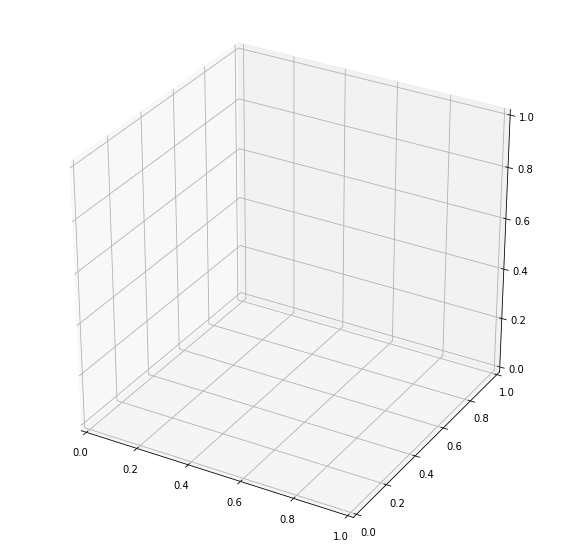

In [2]:


lx = 1000
dxMin = 10

nC = 2**int(np.log2(lx/dxMin))
width = dxMin * nC
dxMax = width/4
maxLevel = int(np.log2(dxMax / dxMin))

# Define topo and refine around max values
topoLim = width/4
topo = np.r_[np.c_[-topoLim,-topoLim,0.5],
             np.c_[-topoLim,topoLim,0.5],
             np.c_[topoLim,-topoLim,0.5],
             np.c_[topoLim,topoLim,0.5]]

mesh = Mesh.TreeMesh([np.ones(nC)*dxMin, np.ones(nC)*dxMin, np.ones(nC)*dxMin])
mesh.x0 = np.r_[-width/2,-width/2,-width + topo[:,2].max() + (dxMin*8)]

mesh.refine(2)
def refineFun(level, xExtent, yExtent, zExtent):

    def refine(cell):
        xyz = cell.center + mesh.x0
        if np.all([xyz[0]>xExtent[0], xyz[0]<xExtent[1],
                   xyz[1]>yExtent[0], xyz[1]<yExtent[1],
                   xyz[2]>zExtent[0], xyz[2]<zExtent[1]]):
            return level
        return 0
    return refine

xExtent = np.r_[topo[:,0].min(), topo[:,0].max()] 
yExtent = np.r_[topo[:,1].min(), topo[:,1].max()] 
zExtent = np.r_[topo[:,2].min()-80, topo[:,2].max()+80]

for ii in range(maxLevel):
    
    level = ii + 3
    zWindow = dxMin*2**(maxLevel - level + 2)
    mesh.refine(refineFun(level, xExtent, yExtent,
                       [topo[:,2].min()-zWindow*8,
                        topo[:,2].max()+zWindow*2]))


plt.figure(figsize=(10,10))
ax = plt.subplot(projection='3d')
# M.plotGrid(ax=ax)

# Get upper and lower corners of each cell
bsw = mesh.gridCC - np.kron(mesh.vol.T**(1/3)/2, np.ones(3)).reshape((mesh.nC,3))
tne = mesh.gridCC + np.kron(mesh.vol.T**(1/3)/2, np.ones(3)).reshape((mesh.nC,3))


# Define active cells
zTopo = griddata(topo[:, :2], topo[:, 2], mesh.gridCC[:,:2], method='nearest', fill_value=np.nan)
actInd = zTopo > mesh.gridCC[:,2]

Mesh.TreeMesh.writeUBC(mesh, 'OctreeTest.msh', models= {'ActiveOctree.dat':actInd} )


In [3]:
mesh.x0

array([-320. , -320. , -559.5])

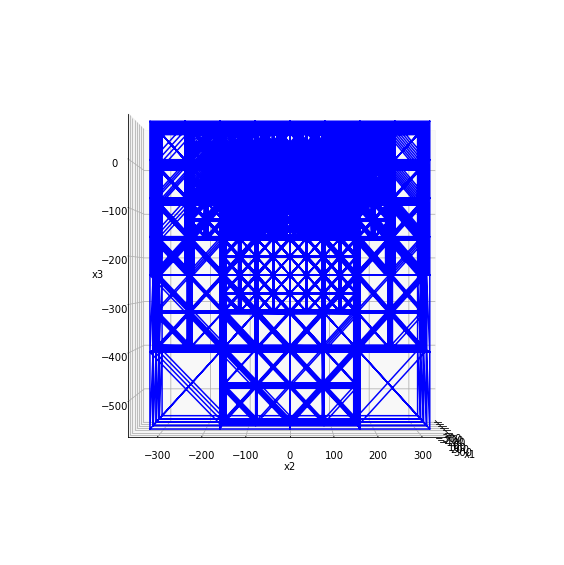

In [4]:
ax = plt.subplot(projection='3d')
mesh.plotGrid(ax=ax)

ax.view_init(0, 0)
ax.set_aspect('equal')
plt.show()

In [11]:

# Define the inducing field parameter
B = (50000, 90, 0)

# Create and array of observation points
xr = np.linspace(-30., 30., 20)
yr = np.linspace(-30., 30., 20)
X, Y = np.meshgrid(xr, yr)

# Move the observation points 5m above the topo
Z = np.ones(X.shape)*topo[:,2].max() + 10

# Create a MAGsurvey
xyzLoc = np.c_[Utils.mkvc(X.T), Utils.mkvc(Y.T), Utils.mkvc(Z.T)]
rxLoc = PF.BaseMag.RxObs(xyzLoc)
srcField = PF.BaseMag.SrcField([rxLoc], param=B)
survey = PF.BaseMag.LinearSurvey(srcField)

# We can now create a susceptibility model and generate data
# Here a simple block in half-space
susc = 0.1
nX = 1

# Get index of the center of block
midx = 0
midy = 0
midz = -30

model = np.zeros(mesh.nC)
p0 = np.r_[midx, midy, midz] - nX*dxMin
p1 = np.r_[midx, midy, midz] + nX*dxMin
actBlock = Utils.ModelBuilder.getIndicesBlock(p0, p1, mesh.gridCC)
    
model[actBlock] = susc
m = model[actInd]

# Create active map to go from reduce set to full
actvMap = Maps.InjectActiveCells(mesh, actInd, 0)

Mesh.TreeMesh.writeUBC(mesh, 'OctreeTest.msh', models= {'OctreeModel.dat':actvMap*m} )
# G=mesh._cellGradyStencil()
# gradm = G.T*(G*model)
# mesh.cellGradStencil.shape


Begin calculation of forward operator: ind
Done 0.0 %
Done 10.0 %
Done 20.0 %
Done 30.0 %
Done 40.0 %
Done 50.0 %
Done 60.0 %
Done 70.0 %
Done 80.0 %
Done 90.0 %
Done 100% ...forward operator completed!!



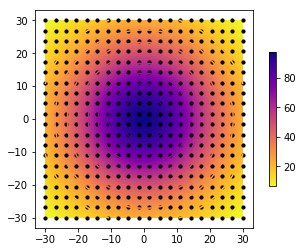

In [12]:
# Number of active cells
nC = int(actInd.sum())

# Create reduced identity map
idenMap = Maps.IdentityMap(nP=nC)

# Create the forward problem (forwardOnly)
prob = PF.Magnetics.MagneticIntegral(mesh, chiMap=idenMap, actInd=actInd)

# Pair the survey and problem
survey.pair(prob)

# Compute forward model some data
d = prob.fields(m)

nD = survey.nD

wd = np.ones(len(d))  # Assign flat uncertainties
survey.dobs = d
survey.std = wd

fig, im = PF.Magnetics.plot_obs_2D(survey.srcField.rxList[0].locs, d=d)
plt.show()

In [13]:
# Create a regularization function, in this case l2l2
wr = np.sum(prob.G**2., axis=0)**0.5
wr = (wr/np.max(wr))

# Create a regularization
reg = Regularization.Sparse(mesh, indActive=actInd, mapping=idenMap)
reg.norms = [0,1,1,1]
reg.cell_weights = wr
# reg_Susc.objfcts[1].cell_weights = np.ones_like(wr)
# reg_Susc.objfcts[2].cell_weights = np.ones_like(wr)
# reg_Susc.objfcts[3].cell_weights = np.ones_like(wr)
# Data misfit function
dmis = DataMisfit.l2_DataMisfit(survey)
dmis.W = 1/wd

# Add directives to the inversion
opt = Optimization.ProjectedGNCG(maxIter=100, lower=0., upper=1.,
                                 maxIterLS=20, maxIterCG=10, tolCG=1e-3)
invProb = InvProblem.BaseInvProblem(dmis, reg, opt)
betaest = Directives.BetaEstimate_ByEig()

# Here is where the norms are applied
# Use pick a treshold parameter empirically based on the distribution of
#  model parameters
IRLS = Directives.Update_IRLS(f_min_change=1e-3, minGNiter=3)

update_Jacobi = Directives.UpdateJacobiPrecond()
inv = Inversion.BaseInversion(invProb,
                              directiveList=[ betaest,IRLS, update_Jacobi])



SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||


In [14]:
# Run the inversion
m0 = np.ones(nC)*1e-4  # Starting model
mrec_SUS = inv.run(m0)

SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
Approximated diag(JtJ) with linear operator
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  2.40e+10  4.14e+05  1.62e-07  4.18e+05    5.55e+01      0              
   1  1.20e+10  3.18e+05  1.80e-06  3.39e+05    5.67e+01      0              
   2  5.99e+09  2.63e+05  5.10e-06  2.94e+05    5.49e+01      0   Skip BFGS  
   3  3.00e+09  1.99e+05  1.28e-05  2.38e+05    5.46e+01      0   Skip BFGS  
   4  1.50e+09  1.41e+05  2.67e-05  1.81e+05    5.42e+01      0   Skip BFGS  
   5  7.49e+08  9.86e+04  4.66e-05  1.33e+05    5.30e+01      0   Skip BFGS  
   6  3.75e+08  7.01e+

In [ ]:
Mesh.TreeMesh.writeUBC(mesh, 'OctreeTest.msh', models= {'Model_l2.sus':actvMap*IRLS.l2model} )
Mesh.TreeMesh.writeUBC(mesh, 'OctreeTest.msh', models= {'Model_lp.sus':actvMap*mrec_SUS} )

In [ ]:
mRand = np.ones(actInd.sum())
mRand[100] = 2#np.abs(np.random.randn(actInd.sum()))
Mesh.TreeMesh.writeUBC(mesh, 'OctreeTest.msh', models= {'TestDeriv.sus':actvMap*(reg_Susc.regmesh.aveFz2CC*(reg_Susc.regmesh.aveCC2Fz*mRand))+1e-3} )
Mesh.TreeMesh.writeUBC(mesh, 'OctreeTest.msh', models= {'Rand.sus':actvMap*mRand})

In [ ]:
x = np.r_[-500., -500., -500, -500, -500, -250, 0, 250, 250, 250, 0 ,-250, 600, 600 ,600, 600, 600, 850, 1100, 850]
y = np.zeros_like(x)
z = np.r_[-500, -250, 0 ,250, 500, 500, 250, 0, -250, -500, -500, -500, -500, -250, 0 ,250, 500, 500,500, 0]
xyz = np.c_[x, y, z]
h = np.r_[25., 25., 25.]
padDist = np.ones((3,2)) * 5e3
mesh = Utils.modelutils.meshBuilder(xyz, h, padDist, meshType="TREE")
mesh.writeUBC("DF.msh")
np.savetxt('DF.dat', xyz, fmt='%i')

In [ ]:
mesh.